In [1]:
#%matplotlib widget
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage


In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            yield image
        else:
            return

def crop(im, bottom=100, top=220):
    # take of top and bottom
    return im[top:im.shape[0]-bottom,:]

def tile(im, nrows=1, ncolumns=6):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for y in range(0,N*ncolumns,N):
        row = []
        for x in range(0,M*nrows,M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    return rows

def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)

def quick_view(fs, frames_per_step=1, start=1000, stop=1010):
    for i, im in enumerate(fs):
        if not (start<i<stop):
            if i>stop:
                break
            continue
        if i % frames_per_step != 0:
            continue
        cv2.imshow('oned',im)
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()

In [3]:
def cframes():
    for im in frames():
        yield crop(im)

In [4]:
#quick_view(cframes(), frames_per_step=1, start=60, stop=180)

In [5]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()
xs=[]
for i, f in enumerate(cframes()):
    tiles = tile(f,8,20)
    #tiles = tile(f,3,8)
    xs.append([variance_of_laplacian(i) for i in flatten(tiles)])
    if i % 1000 == 0:
        print('.', end='')

.....................

In [30]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)

Xy = X.copy(deep=True)
Xy['y'] = y

chunksize = 60
chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,y
14280,24.047959,22.445343,26.388141,24.937511,8.296983,4.610056,10.880317,19.624440,94.912907,43.392198,...,9.349375,8.222178,8.728708,21.733750,13.681931,4.905434,1.968271,6.448376,6.759544,4.884701
14281,28.486370,22.855896,24.978494,23.402322,8.136918,3.485818,7.348086,20.377855,53.161261,41.107485,...,8.854203,8.226667,7.109796,16.995453,10.768207,4.512148,0.810260,4.625885,6.332253,4.892872
14282,30.399961,23.106667,26.777969,25.881847,8.501292,5.258193,5.352940,20.666107,39.398155,35.107524,...,8.983370,9.949386,13.891657,20.810714,9.615004,4.976723,1.533832,5.147732,6.245693,5.016715
14283,25.517328,17.601162,22.825677,25.308689,8.435980,6.862986,5.114427,20.186007,28.005794,29.220273,...,8.992745,9.149001,14.892589,20.186169,9.786449,5.087960,0.934698,4.772829,6.202940,5.146137
14284,25.366599,18.891222,30.507354,25.014197,8.746912,6.377881,8.889834,21.036058,27.325818,36.123676,...,9.143919,9.815537,18.415615,30.442615,12.396749,7.535388,0.614041,4.490082,5.829792,5.279314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,9.015381,15.299750,5.109698,2.639495,3.457751,2.413813,1.468110,15.143207,65.535479,119.693194,...,4.763943,72.484219,29.296894,10.750108,251.495447,102.694753,0.565381,0.478448,4.478542,21.561345
3260,6.133896,14.722178,5.925065,2.851003,3.065146,2.480094,1.450401,14.307810,9.174770,91.954417,...,4.559893,33.105837,36.951697,11.511370,267.632152,116.850460,0.730898,0.297917,5.382563,21.576007
3261,6.409023,19.847699,4.984808,209.241222,2.852881,2.337537,1.454568,13.732282,8.848607,54.080564,...,4.381573,20.874099,28.717348,10.444782,281.058370,110.126150,0.692680,0.329685,4.772126,21.578388
3262,7.159600,70.359857,4.257594,238.095794,2.961781,1.757843,2.034347,14.037490,104.911042,24.113711,...,4.666667,11.464964,43.076462,15.108177,212.803754,3.789555,1.044268,1.312490,5.722953,21.569636


In [31]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [154]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

pipe = Pipeline([
        ('scale', StandardScaler()),
        #'reduce_dims', PCA(n_components=4)),
        #('svr', SVR(C=20)),
        #('rf', RandomForestRegressor()),
        #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
        #('br', BayesianRidge()),
        ('stack', StackingRegressor([
            ('svr', SVR(C=20)),
            ('rf', RandomForestRegressor()),
            ('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
            ]))
    ])

# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    #'svr__C':[.01, .1, .3, .9, 2, 4, 10, 20],
    #'svr__C':[10, 20, 30, 40, 70, 120],
    'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],RandomForestRegressor
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=5, cv=5)

m_real = pipe


In [155]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Pipeline(steps=[('scale', StandardScaler()),
                ('stack',
                 StackingRegressor(estimators=[('svr', SVR(C=20)),
                                               ('rf', RandomForestRegressor()),
                                               ('mlp',
                                                MLPRegressor(alpha=0.1,
                                                             shuffle=False))]))])


In [156]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [157]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.00035]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
kf_tuned = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [158]:
# never below 0
Xy2.loc[Xy2['pred']<0.0,'pred'] = 0.0

In [159]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf_tuned.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [160]:
Xy2

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,y,is_test,dum,pred,pred_kf
0,4.279157,2.655381,4.595378,2.234336,1.498904,1.251541,0.550000,2.125000,4.503688,5.368728,...,105.714555,4.114469,0.966143,0.623870,1.160525,28.105569,False,10.690719,28.076964,NaN
1,4.296631,3.596788,5.068532,2.227257,1.406358,1.890625,1.030434,2.373630,48.746875,7.763474,...,109.032517,10.646136,1.962999,1.308656,1.826719,28.105569,False,10.690719,27.942261,NaN
2,10.138792,2.882205,5.266211,5.952992,1.632973,1.978526,1.101899,2.263969,116.996462,6.500173,...,102.366969,17.473025,1.245473,1.091990,1.989529,28.106527,False,10.690719,28.327965,NaN
3,77.734145,2.861000,4.941657,65.875460,1.503125,1.928376,1.460016,3.043064,58.227973,5.984365,...,100.939626,17.584365,1.587565,1.230199,1.712986,28.130404,False,10.690719,28.104096,NaN
4,76.785371,2.812673,4.820147,64.229167,1.345942,1.893594,1.034023,2.986405,11.533669,7.691657,...,95.757224,26.244753,1.822777,1.114906,1.618787,28.109243,False,10.690719,28.177872,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,45.019391,30.535065,7.827148,4.982178,7.926214,2.958584,4.323480,24.176528,171.392185,88.380381,...,4.581927,19.326927,8.853750,15.016042,3.633177,2.329180,False,10.690719,1.195593,NaN
20396,46.228754,35.795677,7.898558,5.786762,12.918975,3.426462,4.984412,23.281315,154.104079,82.523844,...,4.782253,19.261761,8.689583,18.395482,3.720805,2.289795,False,10.690719,0.913510,NaN
20397,62.792148,41.891182,9.109600,6.209158,10.297565,5.719753,4.240511,23.143610,163.410876,70.277074,...,3.753115,14.525625,6.406508,16.414060,4.142568,2.292917,False,10.690719,1.131928,NaN
20398,86.626475,50.360052,13.866449,7.150271,15.218695,7.816263,4.542100,25.254792,204.503298,77.310537,...,3.685065,21.219704,7.981195,18.622426,3.595589,2.260600,False,10.690719,1.056753,NaN


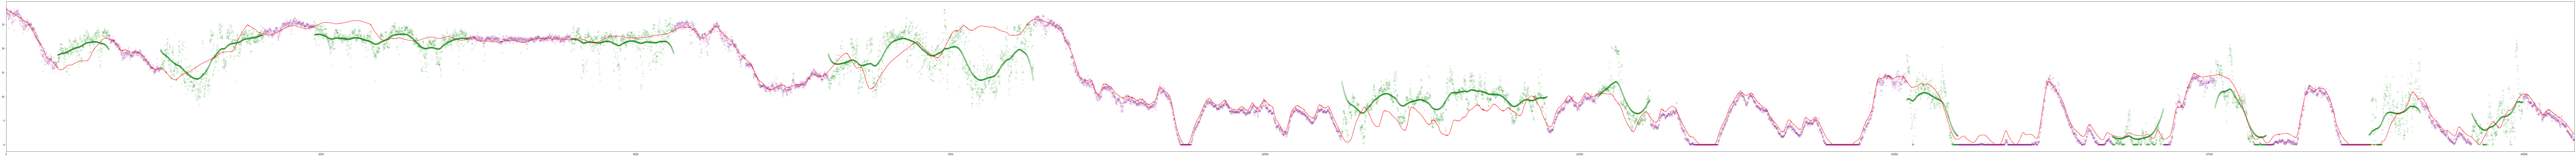

In [163]:
plt.rcParams['figure.figsize'] = [200, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    if ix_mask is None:
        df = Xy2.loc[:,column]
    else:
        df = Xy2.loc[ix_mask, column]
    plt.plot(df.index, df.values, **kwargs)
    
plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)
plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')

In [162]:
def print_summary_line(ix_mask, column='dum'):
    Xy = Xy2[ix_mask]
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end=' ')

print(f"dummy test train test_kf")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')

dummy test train test_kf
78.7 15.6 0.9 11.1 